# Loading the Training Data

In [1]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import polars as pl

# Directory containing the testing images
train_dir = 'data/set-A_train'
test_dir = 'data/set-B_test'

# load labels
train_labels_df = pl.read_csv(f'{train_dir}/image_labels.csv')
test_labels_df = pl.read_csv(f'{test_dir}/image_labels.csv')

# Row and col limits (everything outside is irrelevant)
ORIG_IMG_ROW_LIM_1  = 60
ORIG_IMG_ROW_LIM_2  = 430
ORIG_IMG_COL_LIM_1  = 40
ORIG_IMG_COL_LIM_2  = 600


# Load images from test set
train_images = []
train_labels = []
for filename in tqdm(os.listdir(train_dir), desc='Loading images from train data'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(train_dir, filename)
        img = Image.open(img_path)
        img = img.crop((ORIG_IMG_COL_LIM_1, ORIG_IMG_ROW_LIM_1, ORIG_IMG_COL_LIM_2, ORIG_IMG_ROW_LIM_2))  # Crop the image
        img_array = np.array(img)
        train_images.append(img_array)
        train_labels.append(filename)

train_images = np.array(train_images)
print(f'Loaded {len(train_images)} images for training.')

# Load images from test set
test_images = []
test_labels = []
for filename in tqdm(os.listdir(test_dir), desc='Loading images from test data'):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path)
        img = img.crop((ORIG_IMG_COL_LIM_1, ORIG_IMG_ROW_LIM_1, ORIG_IMG_COL_LIM_2, ORIG_IMG_ROW_LIM_2))  # Crop the image
        img_array = np.array(img)
        test_images.append(img_array)
        test_labels.append(filename)

test_images = np.array(test_images)
print(f'Loaded {len(test_images)} images for testing.')

Loading images from train data: 100%|██████████| 1636/1636 [00:06<00:00, 262.74it/s]


Loaded 1635 images for training.


Loading images from test data: 100%|██████████| 401/401 [00:01<00:00, 291.85it/s]


Loaded 400 images for testing.


## Pre-Processing

In [ ]:
def preprocess_images_ship_present(images, labels, labels_df, target_size=(128, 128)):

    processed_images = []
    is_nonempty_labels = []
    locations = []
    heading = []
    shiptype = []


    for img, label in tqdm(zip(images, labels), desc='Preprocessing images\t', total=len(images)):
        # Resize the image
        img_resized = Image.fromarray(img).resize(target_size)
        img_array = np.array(img_resized)
        
        # Normalize the pixel values
        img_normalized = img_array / 255.0
        
        processed_images.append(img_normalized)
        # Append the corresponding Is_nonempty value
        is_nonempty = labels_df.filter(pl.col('Filename') == label)['Is_nonempty'][0]
        is_nonempty_labels.append(is_nonempty)

        # locations
        is_location = labels_df.filter(pl.col('Filename') == label)['Location'][0]
        locations.append(is_location)

        # locations
        is_heading = labels_df.filter(pl.col('Filename') == label)['Heading'][0]
        heading.append(is_heading)

        # locations
        is_shiptype = labels_df.filter(pl.col('Filename') == label)['Ship'][0]
        shiptype.append(is_shiptype)
        
    return np.array(processed_images), np.array(is_nonempty_labels).reshape(-1,1), locations, heading, shiptype


# Preprocess the images and labels for training
processed_images_train, empty_labels_train, location_label_train, heading_label_train, shiptype_label_train = preprocess_images_ship_present(train_images, train_labels, train_labels_df)
print(f'Processed {len(processed_images_train)} images for training')

processed_images_test, empty_labels_test, location_label_test, location_label_test, shiptype_label_test = preprocess_images_ship_present(test_images, test_labels, test_labels_df)
print(f'Processed {len(processed_images_test)} images for testing')


Preprocessing images	: 100%|██████████| 1635/1635 [00:10<00:00, 156.79it/s]


Processed 1635 images for training


Preprocessing images	: 100%|██████████| 400/400 [00:02<00:00, 162.88it/s]


Processed 400 images for testing


#### Test the processed image

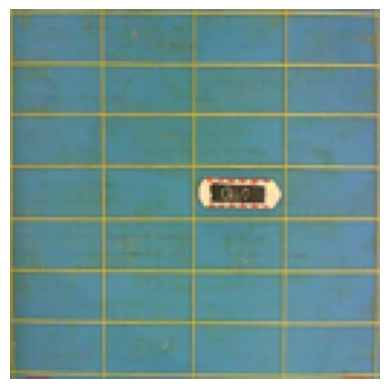

In [3]:
import matplotlib.pyplot as plt

# Display the first image
plt.imshow(processed_images_train[5])
plt.axis('off')  # Hide the axis
plt.show()

# Missing Ship Classifier

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - AUC: 0.5506 - accuracy: 0.8230 - loss: 0.4941 - val_AUC: 0.9500 - val_accuracy: 0.8073 - val_loss: 0.5233
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - AUC: 0.7977 - accuracy: 0.8017 - loss: 0.4431 - val_AUC: 1.0000 - val_accuracy: 0.9969 - val_loss: 0.1001
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - AUC: 0.9945 - accuracy: 0.9844 - loss: 0.0807 - val_AUC: 1.0000 - val_accuracy: 0.9878 - val_loss: 0.0648
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - AUC: 1.0000 - accuracy: 0.9912 - loss: 0.0684 - val_AUC: 1.0000 - val_accuracy: 0.9969 - val_loss: 0.0085
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - AUC: 1.0000 - accuracy: 0.9999 - loss: 5.9515e-04 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 5.1139e-04 - val_AUC: 1.0000 - val_accuracy: 0.9969 - val_loss: 0.0054
Epoch 7/20
41/41 ━━━━━━━━━━━━━

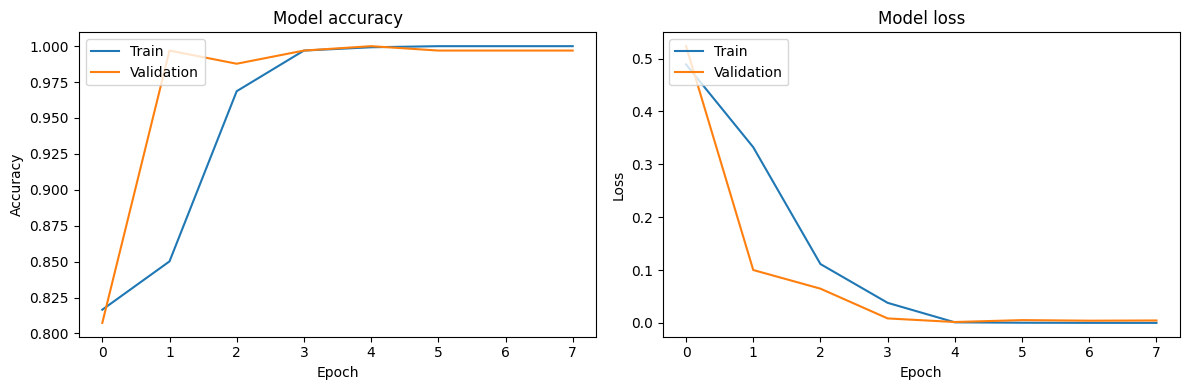

In [4]:
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_ship_present = ShipClassifier()
model_ship_present.build((None, 128, 128, 3))
model_ship_present.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy', 'AUC'])

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(processed_images_train, empty_labels_train, test_size=0.2, random_state=42)

# Train the model with early stopping
history = model_ship_present.fit(
    X_train, 
    y_train, 
    epochs=20,  # Maximum number of epochs
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping],
    verbose=1
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


#### train test set for the Empty vessel analysis

In [5]:
# Get predictions for all validation images
predictions_ship_present = model_ship_present.predict(X_val)

# Convert predictions to binary values (0 or 1) using threshold of 0.5
binary_predictions_ship_present = (predictions_ship_present > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(binary_predictions_ship_present.flatten() == np.array(y_val))
print(f'Validation Accuracy: {accuracy:.4f}')

# Print first few predictions and their actual values
print("\nFirst 10 predictions:")
for i in range(10):
    print(f"Predicted: {binary_predictions_ship_present[i][0]}, Actual: {y_val[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Validation Accuracy: 0.6889

First 10 predictions:
Predicted: 0, Actual: [0]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]


In [ ]:
processed_images_test, empty_labels_test, location_label_test, location_label_test, location_label_test = preprocess_images_ship_present(test_images, test_labels, test_labels_df)

#### Missing Ship on validation Data

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


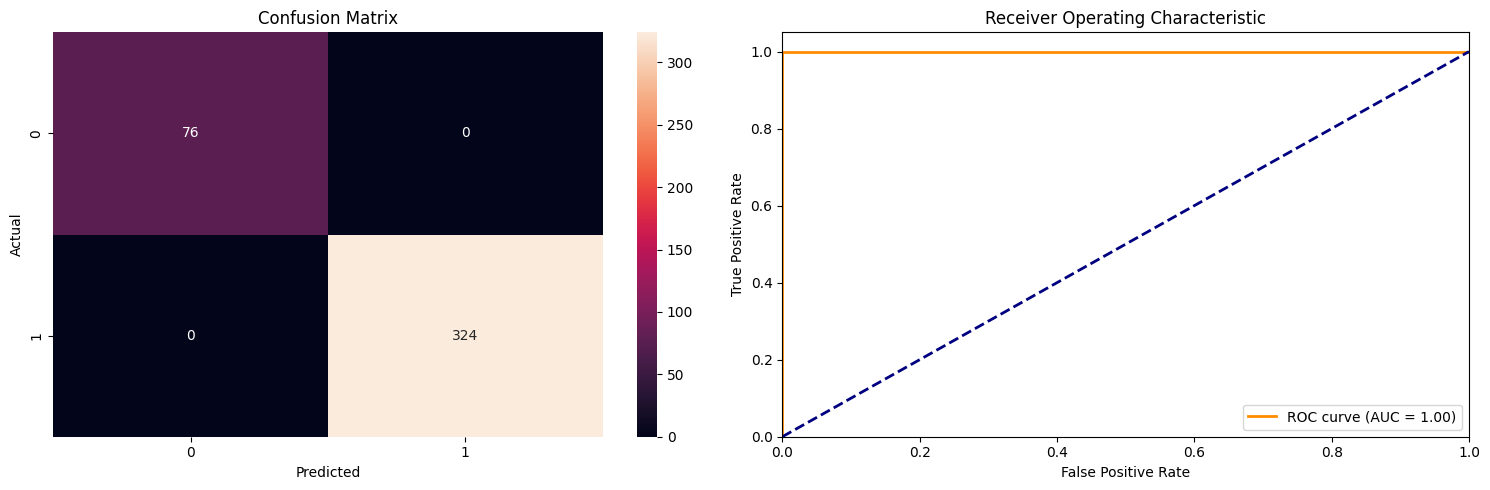


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00       324

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


First 10 predictions:
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]
Predicted: 0, Actual: [0]
Predicted: 1, Actual: [1]
Predicted: 1, Actual: [1]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

## Validation Data


# Get predictions for all test images
predictions_ship_present = model_ship_present.predict(processed_images_test)

# Convert predictions to binary values (0 or 1) using threshold of 0.5
binary_predictions_ship_present = (predictions_ship_present > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(empty_labels_test, binary_predictions_ship_present)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(empty_labels_test, predictions_ship_present)
roc_auc = auc(fpr, tpr)

# Plot confusion matrix and ROC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Plot ROC curve
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(empty_labels_test, binary_predictions_ship_present))

# Print first few predictions and their actual values
print("\nFirst 10 predictions:")
for i in range(10):
    print(f"Predicted: {binary_predictions_ship_present[i][0]}, Actual: {empty_labels_test[i]}")

# Ship Type Classifier

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# First, let's create a copy of the labels and replace None with a string 'None'
shiptype_labels = [str(label) if label is not None else 'None' for label in shiptype_label_train]

# Create and fit the LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(shiptype_labels)

# Create and fit the OneHotEncoder
onehot_encoder = OneHotEncoder()
encoded_labels_reshaped = encoded_labels.reshape(-1, 1)
onehot_labels = onehot_encoder.fit_transform(encoded_labels_reshaped)

# Print the mapping and shape
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("One-hot encoded shape:", onehot_labels.shape)
print("Number of classes:", len(label_encoder.classes_))

# Now onehot_labels can be used for training the classifier

Label mapping: {np.str_('Cruiser-1'): np.int64(0), np.str_('Cruiser-2'): np.int64(1), np.str_('Cruiser-3'): np.int64(2), np.str_('Fishing-1'): np.int64(3), np.str_('Fishing-2'): np.int64(4), np.str_('Freighter'): np.int64(5), np.str_('None'): np.int64(6)}
One-hot encoded shape: (1635, 7)
Number of classes: 7


In [9]:
# Ship Type Classifier
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(len(label_encoder.classes_), activation='softmax')
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_ship_type = ShipClassifier()
model_ship_type.build((None, 128, 128, 3))
model_ship_type.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

# Add early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

X_train, X_val, y_train, y_val = train_test_split(processed_images_train, encoded_labels, test_size=0.2, random_state=42)

# Train the model with callbacks
history = model_ship_type.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - loss: 1.9591 - sparse_categorical_accuracy: 0.1567 - val_loss: 1.9374 - val_sparse_categorical_accuracy: 0.1927 - learning_rate: 0.0010
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 1.9390 - sparse_categorical_accuracy: 0.1866 - val_loss: 1.9272 - val_sparse_categorical_accuracy: 0.1927 - learning_rate: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 1.8970 - sparse_categorical_accuracy: 0.2235 - val_loss: 1.7281 - val_sparse_categorical_accuracy: 0.3792 - learning_rate: 0.0010
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 1.4400 - sparse_categorical_accuracy: 0.4417 - val_loss: 1.3223 - val_sparse_categorical_accuracy: 0.5015 - learning_rate: 0.0010
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.6651 - val_loss: 0.8184 - val_sparse_categorical_accuracy: 0.6942 - learning_rate: 0.0010
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/st

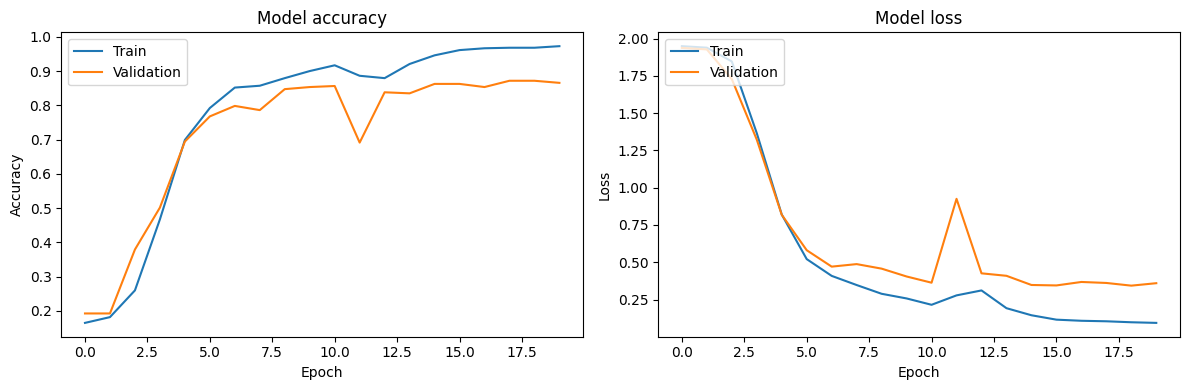

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


#### Train-Test eval for ship type

In [19]:
# Get predictions for all validation images
predictions = model_ship_type.predict(X_val)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert numeric predictions back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)
actual_labels = label_encoder.inverse_transform(y_val)

# Calculate accuracy
accuracy = np.mean(predicted_classes == y_val)

print(f'Validation Accuracy: {accuracy:.4f}')

# Print first 50 predictions and their actual labels
print("\nFirst 50 predictions:")
for i in range(50):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Validation Accuracy: 0.8716

First 50 predictions:
Predicted: None, Actual: None
Predicted: Fishing-1, Actual: Cruiser-2
Predicted: Freighter, Actual: Freighter
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Fishing-2, Actual: Fishing-1
Predicted: Fishing-2, Actual: Fishing-1
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Fishing-1, Actual: Fishing-2
Predicted: Freighter, Actual: Freighter
Predicted: Fishing-1, Actual: Cruiser-2
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Fishing-1, Actual: Fishing-1
Predicted: None, Actual: None
Predicted: Fishing-1, Actual: Fishing-2
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Fishing-2, Actual: Fishing-2
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Fishing-2, Actual: Fishing-2
Predicted

#### Validation Eval for Ship Type

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


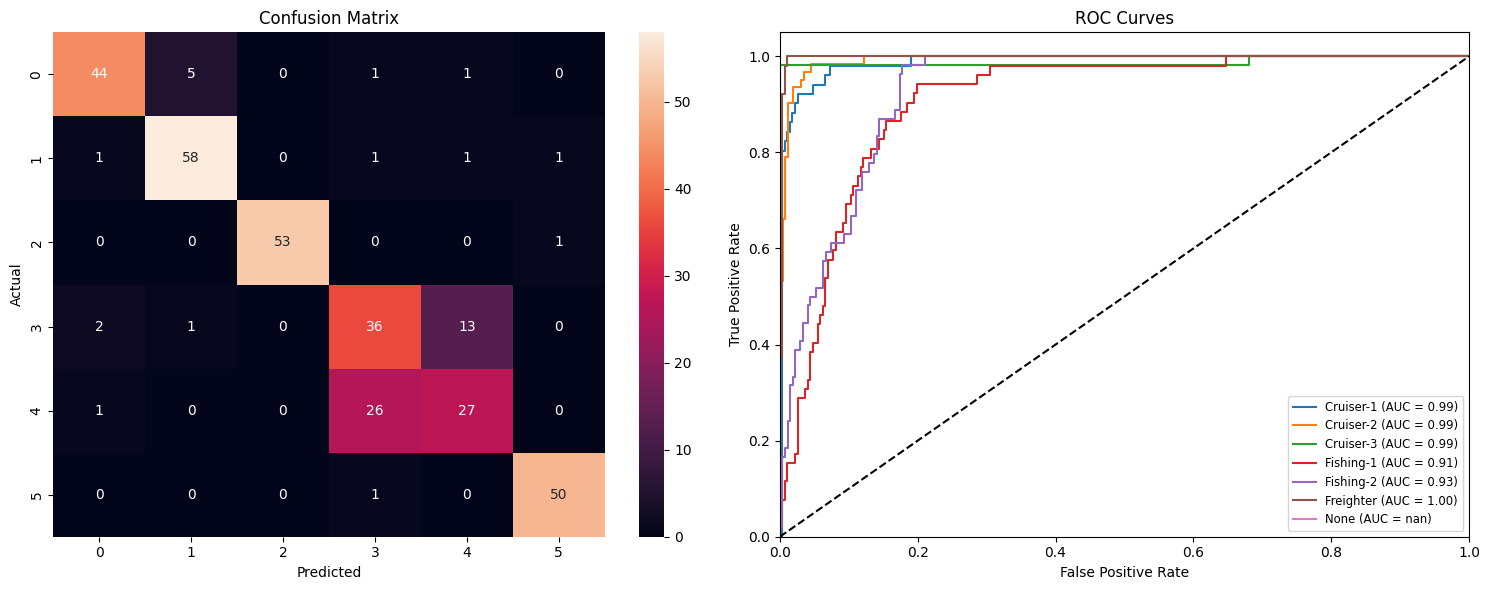


Classification Report:
              precision    recall  f1-score   support

   Cruiser-1       0.92      0.86      0.89        51
   Cruiser-2       0.91      0.94      0.92        62
   Cruiser-3       1.00      0.98      0.99        54
   Fishing-1       0.55      0.69      0.62        52
   Fishing-2       0.64      0.50      0.56        54
   Freighter       0.96      0.98      0.97        51

    accuracy                           0.83       324
   macro avg       0.83      0.83      0.82       324
weighted avg       0.83      0.83      0.83       324


First 10 valid predictions:
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-2, Actual: Cruiser-2
Predicted: Fishing-1, Actual: Fishing-2
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-3, Actual: Cruiser-3
Predicted: Cruiser-1, Actual: Cruiser-1
Predicted: Fishing-2, Actual: Fishing-2
Predicted: Cruiser-2, Actual: Cruiser-2


In [ ]:
# Get predictions for all test images
predictions_ship_location = model_ship_type.predict(processed_images_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions_ship_location, axis=1)

# Convert numeric predictions back to original labels
predicted_ship_location = label_encoder.inverse_transform(predicted_classes)

# Filter out None values
valid_indices = [i for i, x in enumerate(location_label_test) if x is not None]
filtered_actual = [location_label_test[i] for i in valid_indices]
filtered_predicted = [predicted_ship_location[i] for i in valid_indices]

# Create confusion matrix
cm = confusion_matrix(filtered_actual, filtered_predicted)

# Plot confusion matrix and metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Compute and plot ROC curve for each class
n_classes = len(label_encoder.classes_)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Convert to binary classification problem for each class
    y_true_binary = np.array([1 if x == label_encoder.classes_[i] else 0 for x in filtered_actual])
    y_pred_binary = predictions_ship_location[valid_indices][:, i]
    
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    ax2.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend(loc="lower right", fontsize='small')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(filtered_actual, filtered_predicted))

# Print first few predictions
print("\nFirst 10 valid predictions:")
for i in range(10):
    if i < len(valid_indices):
        idx = valid_indices[i]
        print(f"Predicted: {predicted_ship_location[idx]}, Actual: {location_label_test[idx]}")

# Ship Heading Classifier

In [22]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# First, let's create a copy of the labels and replace None with a string 'None'
heading_labels = [str(label) if label is not None else 'None' for label in heading_label_train]

# Create and fit the LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(heading_labels)

# Create and fit the OneHotEncoder
onehot_encoder = OneHotEncoder()
encoded_labels_reshaped = encoded_labels.reshape(-1, 1)
onehot_labels = onehot_encoder.fit_transform(encoded_labels_reshaped)

# Print the mapping and shape
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("One-hot encoded shape:", onehot_labels.shape)
print("Number of classes:", len(label_encoder.classes_))

# Now onehot_labels can be used for training the classifier

Label mapping: {np.str_('East'): np.int64(0), np.str_('None'): np.int64(1), np.str_('West'): np.int64(2)}
One-hot encoded shape: (1635, 3)
Number of classes: 3


In [23]:
# Ship Type Classifier
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(len(label_encoder.classes_), activation='softmax')
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_heading = ShipClassifier()
model_heading.build((None, 128, 128, 3))
model_heading.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
X_train, X_val, y_train, y_val = train_test_split(processed_images_train, encoded_labels, test_size=0.2, random_state=42)

# Train the model
history = model_heading.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.4017 - loss: 1.1046 - val_accuracy: 0.3853 - val_loss: 1.0478
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.4319 - loss: 0.9523 - val_accuracy: 0.5994 - val_loss: 0.7782
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.6896 - loss: 0.6509 - val_accuracy: 0.6055 - val_loss: 0.6070
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.6983 - loss: 0.5349 - val_accuracy: 0.6758 - val_loss: 0.5192
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.7469 - loss: 0.4888 - val_accuracy: 0.7339 - val_loss: 0.4669
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.8096 - loss: 0.3888 - val_accuracy: 0.8043 - val_loss: 0.3901
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.8928 - loss: 0.2507 - val_accuracy: 0.8991 - val_loss: 0.2444
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9500 - loss: 0.1524 - val_accuracy: 0

#### train-test evaluation

In [24]:
def evaluate_predictions(X_val, y_val, label_encoder, model, verbose=True, top_n=10):
    # Get predictions for validation data
    predictions = model.predict(X_val)

    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert numeric predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Get actual labels
    actual_labels = label_encoder.inverse_transform(y_val)

    # Calculate accuracy (excluding None values)
    accuracy = np.mean([pred == actual for pred, actual in zip(predicted_labels, actual_labels) if actual is not None])

    if verbose:
        # Print first few predictions and their actual labels
        print(f"\nFirst {top_n} predictions:")
        for i in range(top_n):
            print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}")
        print(f'\nValidation Accuracy: {accuracy:.4f}')

    return predicted_labels, actual_labels, accuracy

predicted_heading, actual_heading, acc_heading = evaluate_predictions(X_val, y_val, label_encoder, model = model_heading, top_n=20)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

First 20 predictions:
Predicted: None, Actual: None
Predicted: West, Actual: West
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: None, Actual: None
Predicted: West, Actual: West
Predicted: East, Actual: East

Validation Accuracy: 0.9633


#### validation set evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


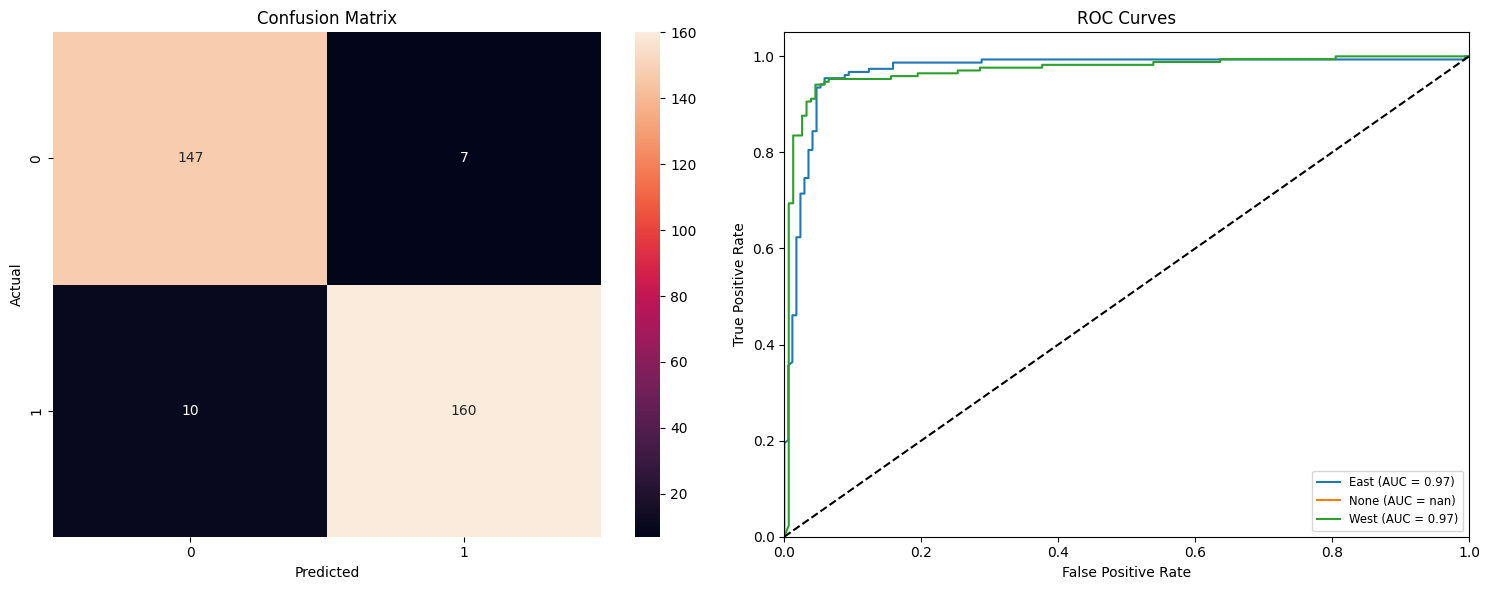


Classification Report:
              precision    recall  f1-score   support

        East       0.94      0.95      0.95       154
        West       0.96      0.94      0.95       170

    accuracy                           0.95       324
   macro avg       0.95      0.95      0.95       324
weighted avg       0.95      0.95      0.95       324


First 10 valid predictions:
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: West, Actual: West
Predicted: West, Actual: West
Predicted: East, Actual: East
Predicted: East, Actual: East
Predicted: West, Actual: West


In [ ]:
# Get predictions for all test images
predictions_ship_location = model_heading.predict(processed_images_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions_ship_location, axis=1)

# Convert numeric predictions back to original labels
predicted_ship_location = label_encoder.inverse_transform(predicted_classes)

# Filter out None values
valid_indices = [i for i, x in enumerate(location_label_test) if x is not None]
filtered_actual = [location_label_test[i] for i in valid_indices]
filtered_predicted = [predicted_ship_location[i] for i in valid_indices]

# Create confusion matrix
cm = confusion_matrix(filtered_actual, filtered_predicted)

# Plot confusion matrix and metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Compute and plot ROC curve for each class
n_classes = len(label_encoder.classes_)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Convert to binary classification problem for each class
    y_true_binary = np.array([1 if x == label_encoder.classes_[i] else 0 for x in filtered_actual])
    y_pred_binary = predictions_ship_location[valid_indices][:, i]
    
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    ax2.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend(loc="lower right", fontsize='small')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(filtered_actual, filtered_predicted))

# Print first few predictions
print("\nFirst 10 valid predictions:")
for i in range(10):
    if i < len(valid_indices):
        idx = valid_indices[i]
        print(f"Predicted: {predicted_ship_location[idx]}, Actual: {location_label_test[idx]}")

# Ship Location Classifier

In [26]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# First, let's create a copy of the labels and replace None with a string 'None'
location_labels = [str(label) if label is not None else 'None' for label in location_label_train]

# Create and fit the LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(location_labels)

# Create and fit the OneHotEncoder
onehot_encoder = OneHotEncoder()
encoded_labels_reshaped = encoded_labels.reshape(-1, 1)
onehot_labels = onehot_encoder.fit_transform(encoded_labels_reshaped)

# Print the mapping and shape
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("One-hot encoded shape:", onehot_labels.shape)
print("Number of classes:", len(label_encoder.classes_))

# Now onehot_labels can be used for training the classifier

Label mapping: {np.str_('1A'): np.int64(0), np.str_('1B'): np.int64(1), np.str_('1C'): np.int64(2), np.str_('1D'): np.int64(3), np.str_('2A'): np.int64(4), np.str_('2B'): np.int64(5), np.str_('2C'): np.int64(6), np.str_('2D'): np.int64(7), np.str_('3A'): np.int64(8), np.str_('3B'): np.int64(9), np.str_('3C'): np.int64(10), np.str_('3D'): np.int64(11), np.str_('4A'): np.int64(12), np.str_('4B'): np.int64(13), np.str_('4C'): np.int64(14), np.str_('4D'): np.int64(15), np.str_('5A'): np.int64(16), np.str_('5B'): np.int64(17), np.str_('5C'): np.int64(18), np.str_('5D'): np.int64(19), np.str_('6A'): np.int64(20), np.str_('6B'): np.int64(21), np.str_('6C'): np.int64(22), np.str_('6D'): np.int64(23), np.str_('7A'): np.int64(24), np.str_('7B'): np.int64(25), np.str_('7C'): np.int64(26), np.str_('7D'): np.int64(27), np.str_('None'): np.int64(28)}
One-hot encoded shape: (1635, 29)
Number of classes: 29


In [27]:
# Ship Type Classifier
from sklearn.model_selection import train_test_split
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

class ShipClassifier(models.Model):
    def __init__(self):
        super(ShipClassifier, self).__init__()
        
        # Define sequential model for easier forward pass
        self.model = keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(len(label_encoder.classes_), activation='softmax')  # 29 classes output
        ])
        
    def call(self, x):
        return self.model(x)

# Create and compile model
model_location = ShipClassifier()
model_location.build((None, 128, 128, 3))
model_location.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])

# Add learning rate scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

X_train, X_val, y_train, y_val = train_test_split(processed_images_train, encoded_labels, test_size=0.2, random_state=42)

# Train the model
history = model_location.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 656ms/step - loss: 2.9306 - sparse_categorical_accuracy: 0.2478 - sparse_top_k_categorical_accuracy: 0.4445 - val_loss: 0.0950 - val_sparse_categorical_accuracy: 0.9969 - val_sparse_top_k_categorical_accuracy: 0.9969 - learning_rate: 0.0010
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9910 - sparse_top_k_categorical_accuracy: 0.9978 - val_loss: 0.1014 - val_sparse_categorical_accuracy: 0.9939 - val_sparse_top_k_categorical_accuracy: 0.9969 - learning_rate: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 646ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9820 - sparse_top_k_categorical_accuracy: 0.9992 - val_loss: 0.1083 - val_sparse_categorical_accuracy: 0.9969 - val_sparse_top_k_categorical_accuracy: 0.9969 - learning_rate: 0.0010
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 671ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.9918 - sparse_top_k_categorical_accuracy: 0.9944 -

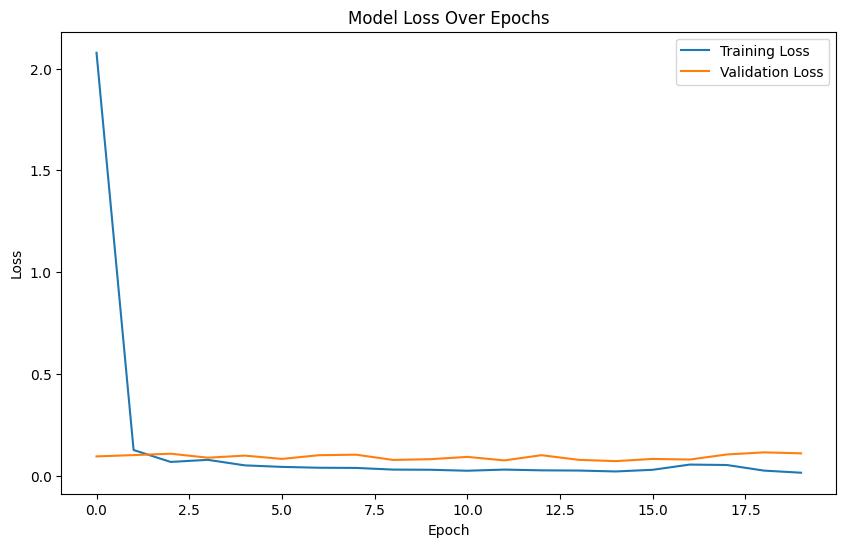

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Train Test Evaluation

In [30]:
def evaluate_predictions(X_val, y_val, label_encoder, model, verbose=True, top_n=10):
    # Get predictions for validation data
    predictions = model.predict(X_val)

    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert numeric predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    # Get actual labels
    actual_labels = label_encoder.inverse_transform(y_val)

    # Calculate accuracy (excluding None values)
    accuracy = np.mean([pred == actual for pred, actual in zip(predicted_labels, actual_labels) if actual is not None])

    if verbose:
        # Print first few predictions and their actual labels
        print(f"\nFirst {top_n} predictions:")
        for i in range(top_n):
            print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}")
        print(f'\nValidation Accuracy: {accuracy:.4f}')

    return predicted_labels, actual_labels, accuracy
predicted_location, actual_location, acc_location = evaluate_predictions(X_val, y_val, label_encoder, model = model_location, top_n=20)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step

First 20 predictions:
Predicted: None, Actual: None
Predicted: 1D, Actual: 1D
Predicted: 7A, Actual: 7A
Predicted: 1D, Actual: 1D
Predicted: 1D, Actual: 1D
Predicted: 4A, Actual: 4A
Predicted: 1B, Actual: 1B
Predicted: 4D, Actual: 4D
Predicted: 7B, Actual: 7B
Predicted: 1A, Actual: 1A
Predicted: 2A, Actual: 2A
Predicted: 1A, Actual: 1A
Predicted: 1D, Actual: 1D
Predicted: 4D, Actual: 4D
Predicted: 1D, Actual: 1D
Predicted: 7C, Actual: 7C
Predicted: 3B, Actual: 3B
Predicted: None, Actual: None
Predicted: 3A, Actual: 3A
Predicted: 1D, Actual: 1D

Validation Accuracy: 0.9969


#### Validation Evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


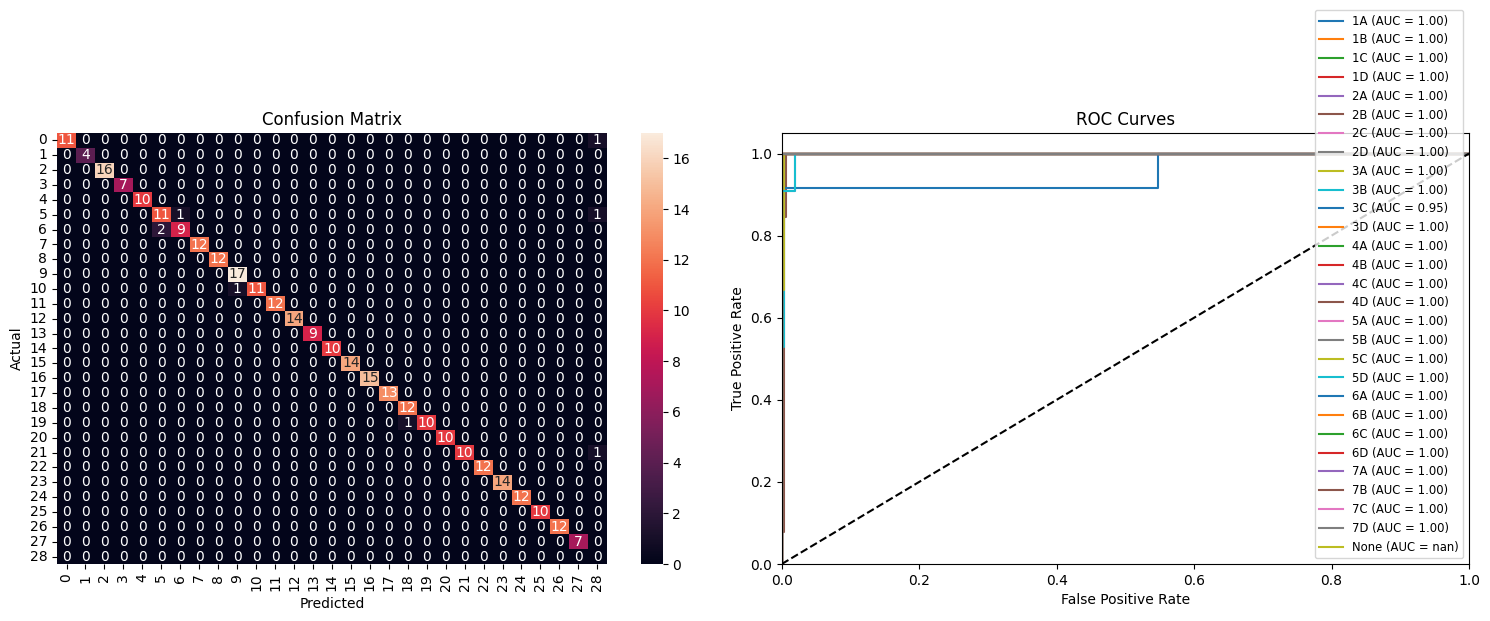


Classification Report:
              precision    recall  f1-score   support

          1A       1.00      0.92      0.96        12
          1B       1.00      1.00      1.00         4
          1C       1.00      1.00      1.00        16
          1D       1.00      1.00      1.00         7
          2A       1.00      1.00      1.00        10
          2B       0.85      0.85      0.85        13
          2C       0.90      0.82      0.86        11
          2D       1.00      1.00      1.00        12
          3A       1.00      1.00      1.00        12
          3B       0.94      1.00      0.97        17
          3C       1.00      0.92      0.96        12
          3D       1.00      1.00      1.00        12
          4A       1.00      1.00      1.00        14
          4B       1.00      1.00      1.00         9
          4C       1.00      1.00      1.00        10
          4D       1.00      1.00      1.00        14
          5A       1.00      1.00      1.00        15
   

e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DS\find-the-ship\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# Get predictions for all test images
predictions_ship_location = model_location.predict(processed_images_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions_ship_location, axis=1)

# Convert numeric predictions back to original labels
predicted_ship_location = label_encoder.inverse_transform(predicted_classes)

# Filter out None values
valid_indices = [i for i, x in enumerate(location_label_test) if x is not None]
filtered_actual = [location_label_test[i] for i in valid_indices]
filtered_predicted = [predicted_ship_location[i] for i in valid_indices]

# Create confusion matrix
cm = confusion_matrix(filtered_actual, filtered_predicted)

# Plot confusion matrix and metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Compute and plot ROC curve for each class
n_classes = len(label_encoder.classes_)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Convert to binary classification problem for each class
    y_true_binary = np.array([1 if x == label_encoder.classes_[i] else 0 for x in filtered_actual])
    y_pred_binary = predictions_ship_location[valid_indices][:, i]
    
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    ax2.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend(loc="lower right", fontsize='small')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(filtered_actual, filtered_predicted))

# Print first few predictions
print("\nFirst 10 valid predictions:")
for i in range(10):
    if i < len(valid_indices):
        idx = valid_indices[i]
        print(f"Predicted: {predicted_ship_location[idx]}, Actual: {location_label_test[idx]}")
